In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


sns.set(style="whitegrid")

In [2]:
import os
print(os.getcwd())  # Shows current working directory


C:\Users\kryan


In [3]:
demog = pd.read_csv("0-JPO_DEMOGRAPHICS_FINAL_2.csv")

demog = demog.drop(columns=['KEY', 'FIN', 'ADMIT','DISC','LOSH','DUR'])
object_cols = demog.select_dtypes(include='object').columns

demog[object_cols] = demog[object_cols].astype('category')
bool_cols = demog.select_dtypes(include='bool').columns

demog[bool_cols] = demog[bool_cols].astype('category')
demog['YEAR_CAT'] = demog['YEAR'].astype('category')


In [4]:
mma = pd.read_csv("unpivot_2.csv")
mma['63'] = mma['63'].astype('float64')
mma = mma.drop(columns=['SUBJECT'])


In [5]:

mma_m = mma.melt(
    id_vars=['EID'],
    var_name='POH',
    value_name='MMA_RATE'
)
mma_m['POH'] = mma_m['POH'].astype('int64')
mma_m = mma_m[~mma_m['MMA_RATE'].isin(["NaN"])]
mma_m = mma_m.dropna(subset=['MMA_RATE'])

mma_m.info()


<class 'pandas.core.frame.DataFrame'>
Index: 118458 entries, 105 to 192540
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   EID       118458 non-null  int64  
 1   POH       118458 non-null  int64  
 2   MMA_RATE  118458 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 3.6 MB


In [6]:
ema = pd.read_csv("Vaps_Hourly_Avg _EMA_2.csv")
ema.rename(columns={'SUBJECT_ID': 'SUBJECT'}, inplace=True)




In [7]:
ema_m = ema.melt(
    id_vars=['SUBJECT'],
    var_name='POH',
    value_name='AVG_VAPS'
)
ema_m = ema_m[~ema_m['AVG_VAPS'].isin(["NaN"])]
ema_m = ema_m.dropna(subset=['AVG_VAPS'])


ema_m['POH'] = ema_m['POH'].astype('int64')


ema_m.info()


<class 'pandas.core.frame.DataFrame'>
Index: 70400 entries, 1 to 207764
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   SUBJECT   70400 non-null  int64  
 1   POH       70400 non-null  int64  
 2   AVG_VAPS  70400 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 2.1 MB


In [8]:
import pandas as pd


subjects = ema_m['SUBJECT'].unique()
poh_values = ema_m['POH'].unique()


full_index = pd.MultiIndex.from_product([subjects, poh_values], names=['SUBJECT', 'POH'])
full_df = pd.DataFrame(index=full_index).reset_index()


merged = full_df.merge(ema_m, on=['SUBJECT', 'POH'], how='left')

ema_m2 = merged.sort_values(['SUBJECT', 'POH'])

ema_m2.info()

# Impute missing AVG_VAPS



<class 'pandas.core.frame.DataFrame'>
Index: 207768 entries, 88352 to 189463
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   SUBJECT   207768 non-null  int64  
 1   POH       207768 non-null  int64  
 2   AVG_VAPS  70400 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 6.3 MB


In [9]:
import numpy as np
import pandas as pd

def impute_with_decay(df, subject_col='SUBJECT', poh_col='POH', value_col='AVG_VAPS', max_gap=6):
    decay_schedule = [1.0, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2]
    imputed_values = []

    for subject, group in df.groupby(subject_col):
        group = group.sort_values(poh_col)
        cum_sum, count = 0, 0
        last_val = None
        gap_counter = 0

        subject_imputed = []

        for val in group[value_col]:
            if not pd.isna(val):
                # Update cumulative stats
                cum_sum += val
                count += 1
                last_val = val
                gap_counter = 0
                imputed = val
            else:
                if last_val is not None and gap_counter < max_gap:
                    lam = decay_schedule[gap_counter]
                    cum_avg = cum_sum / count if count > 0 else last_val
                    imputed = lam * last_val + (1 - lam) * cum_avg
                    gap_counter += 1
                else:
                    imputed = np.nan
            subject_imputed.append(imputed)

        imputed_values.extend(subject_imputed)

   
    df = df.sort_values([subject_col, poh_col]).copy()
    df['VAPS_IMPUTED'] = imputed_values
    return df


ema_m2 = impute_with_decay(ema_m2)
print(ema_m2.head(20))

       SUBJECT  POH  AVG_VAPS  VAPS_IMPUTED
88352        1    0       NaN           NaN
88353        1    1      3.75      3.750000
88354        1    2      0.00      0.000000
88355        1    3      0.00      0.000000
88356        1    4      2.00      2.000000
88357        1    5      0.00      0.000000
88358        1    6       NaN      0.000000
88359        1    7       NaN      0.345000
88360        1    8      1.00      1.000000
88361        1    9       NaN      1.000000
88362        1   10      0.00      0.000000
88363        1   11       NaN      0.000000
88364        1   12       NaN      0.289286
88365        1   13      2.00      2.000000
88366        1   14      2.00      2.000000
88367        1   15       NaN      2.000000
88368        1   16       NaN      1.758333
88369        1   17       NaN      1.677778
88370        1   18      1.00      1.000000
88371        1   19       NaN      1.000000


In [10]:
ema_m2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 207768 entries, 88352 to 189463
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   SUBJECT       207768 non-null  int64  
 1   POH           207768 non-null  int64  
 2   AVG_VAPS      70400 non-null   float64
 3   VAPS_IMPUTED  172579 non-null  float64
dtypes: float64(2), int64(2)
memory usage: 7.9 MB


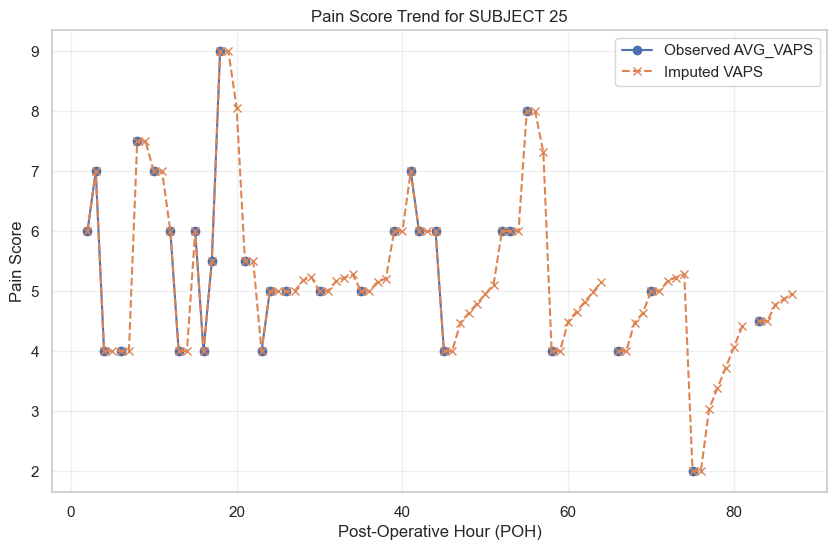

In [11]:
import matplotlib.pyplot as plt


subject_id = 25

  
patient_df = ema_m2[ema_m2['SUBJECT'] == subject_id].sort_values('POH')

# Plot
plt.figure(figsize=(10, 6))
plt.plot(patient_df['POH'], patient_df['AVG_VAPS'], marker='o', label='Observed AVG_VAPS')
plt.plot(patient_df['POH'], patient_df['VAPS_IMPUTED'], marker='x', linestyle='--', label='Imputed VAPS')
plt.title(f'Pain Score Trend for SUBJECT {subject_id}')
plt.xlabel('Post-Operative Hour (POH)')
plt.ylabel('Pain Score')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [12]:
oba = pd.read_csv("nsaid_conda3.csv")
oba = oba.drop(columns=['NSAID_STATUS', 'PAIN', 'NSAID_RATE','POD'])
oba.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207908 entries, 0 to 207907
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   EID          207908 non-null  int64  
 1   POH          207908 non-null  int64  
 2   OME/KG/POH   193781 non-null  float64
 3   CEILING      207908 non-null  float64
 4   capped       207908 non-null  bool   
 5   dose start   207908 non-null  int64  
 6   Unnamed: 10  0 non-null       float64
 7   Unnamed: 11  11 non-null      float64
 8   Unnamed: 12  11 non-null      float64
 9   Unnamed: 13  11 non-null      float64
dtypes: bool(1), float64(6), int64(3)
memory usage: 14.5 MB


In [13]:

demog_cols= ['EID','SUBJECT', 'GROUP', 'TYPE', 'YEAR','YEAR_CAT', 'FAC','FAC_CODE', 'SEX', 'RACE','HT','FAC_PCA_TYPE', 'AGE', 'BMI', 'HW', 'ASA','DSCPOH', 'PCA?','NSAIDS?','HWC']

ema_m2 = ema_m2.merge(demog[['SUBJECT', 'EID']], on='SUBJECT', how='left')
ema_m2 = ema_m2.drop(columns=['SUBJECT'])



merged = pd.merge(oba, ema_m2, on=['EID','POH'], how='left')


master_1 = pd.merge(merged, mma_m, on=['EID','POH'], how='left')
master = master_1.merge(demog[demog_cols], on='EID',how='left')

master.drop(master[master['POH'] > master['DSCPOH']].index, inplace=True)



In [14]:
# Define function for POD assignment
def assign_pod(poh):
    if 0 <= poh <= 15:
        return 'POD-0'
    elif 16 <= poh <= 39:
        return 'POD-1'
    elif 40 <= poh <= 63:
        return 'POD-2'
    else:
        return 'POD-3'


master['POD'] = master['POH'].apply(assign_pod)

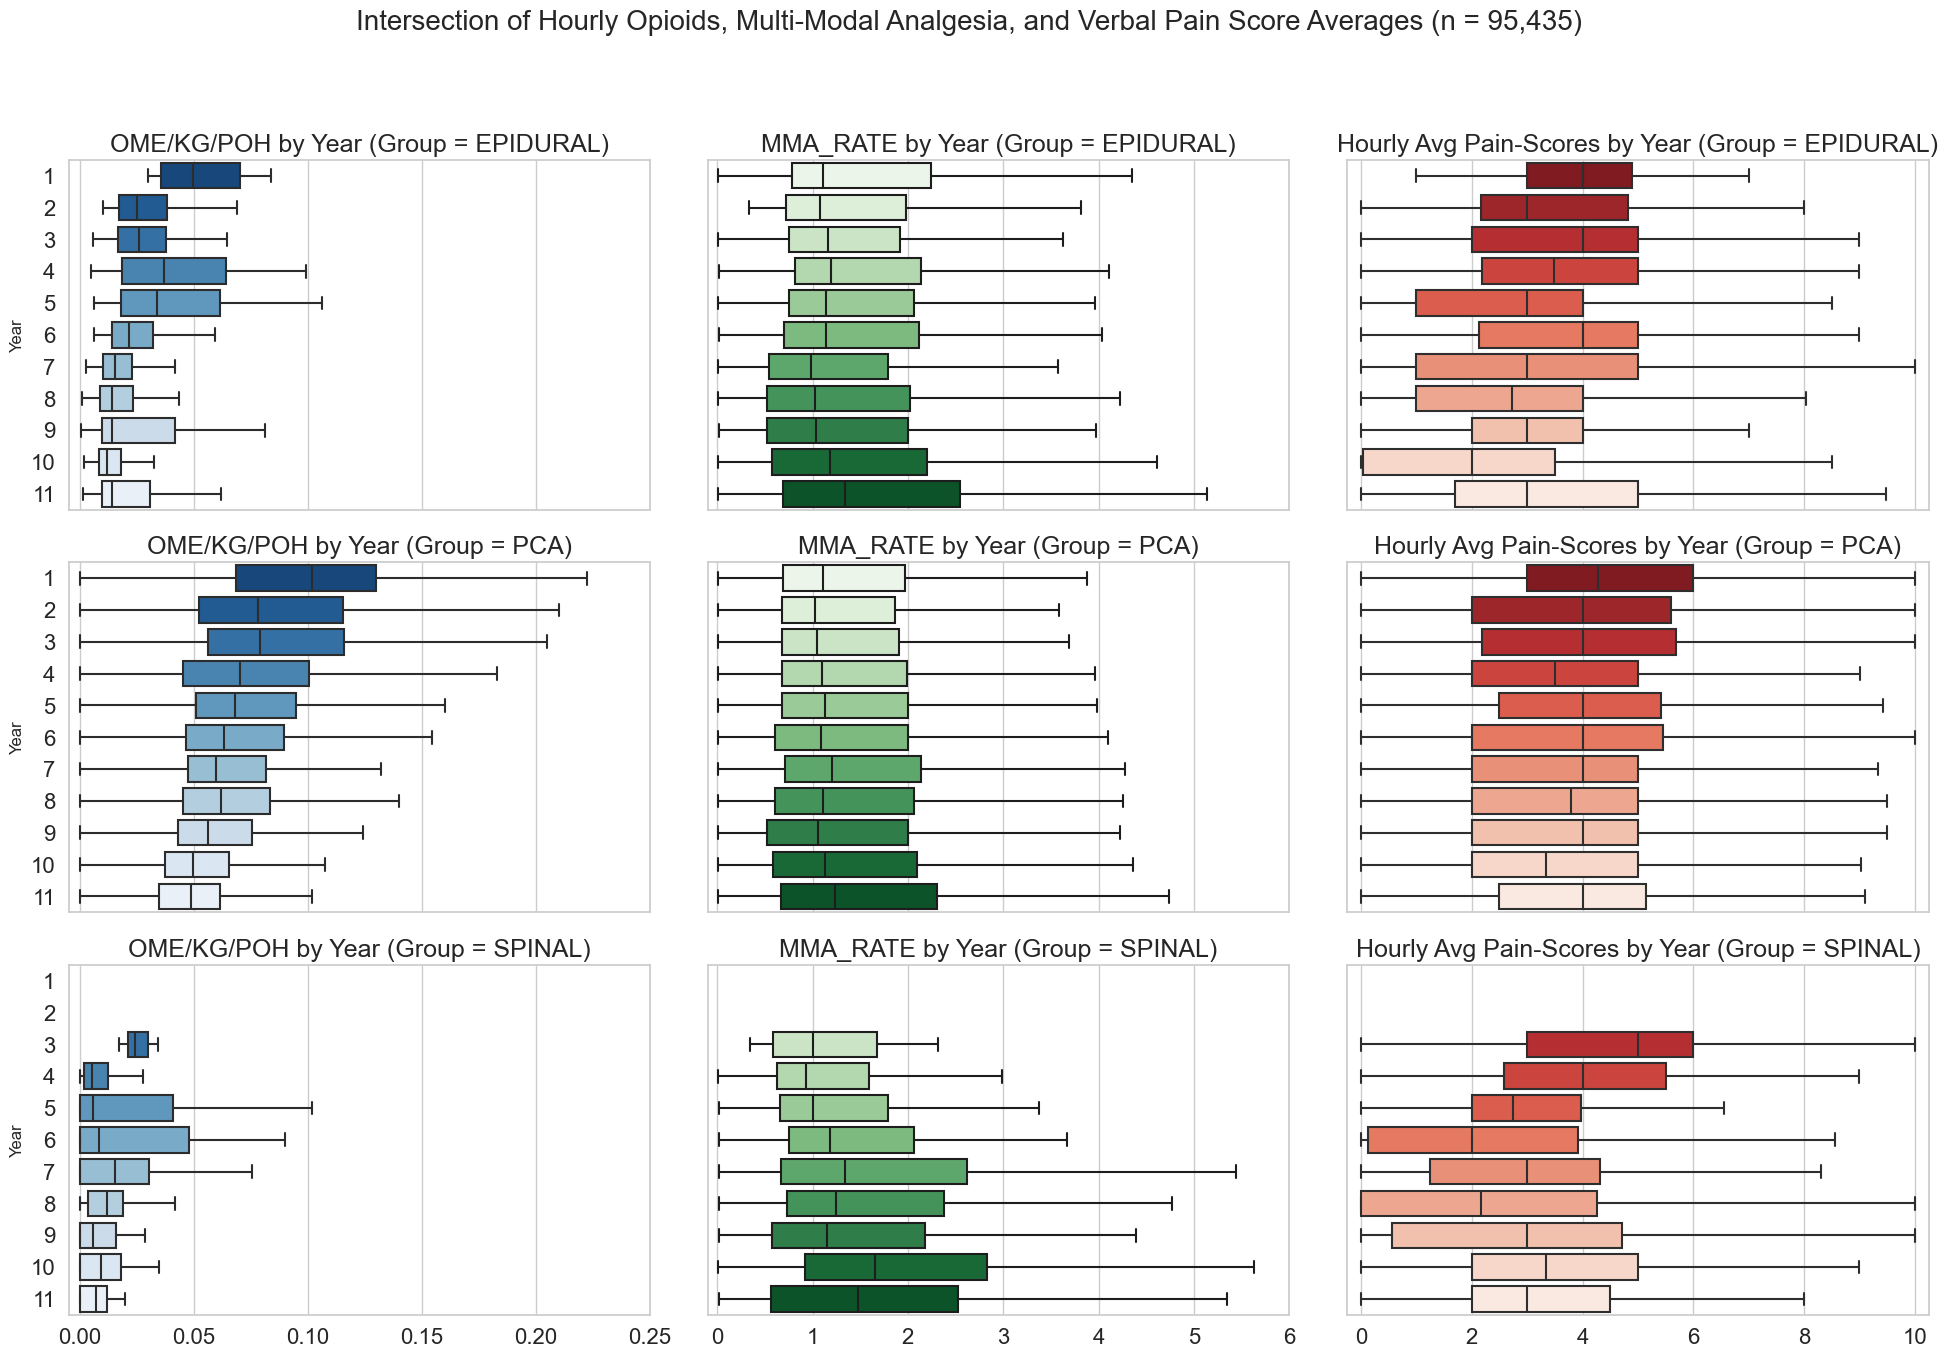

In [15]:
year_order = sorted(master['YEAR'].unique())
pods = sorted(master['GROUP'].unique())
n_pods = len(pods)

fig, axes = plt.subplots(n_pods, 3, figsize=(24, 5 * n_pods), sharey=True)
plt.subplots_adjust(wspace=0.10, hspace=0.15)


if n_pods == 1:
    axes = axes.reshape(1, 3)
else:
    axes = axes.reshape(n_pods, 3)




master_plot = master.dropna(subset=['OME/KG/POH', 'MMA_RATE', 'VAPS_IMPUTED', 'YEAR', 'GROUP']).copy()





for i, pod in enumerate(pods):

    pod_data = master_plot[master_plot['GROUP'] == pod]

   
    sns.boxplot(
        data=pod_data,
        x='OME/KG/POH',
        y='YEAR_CAT',
        order=year_order,
        ax=axes[i, 0],
        orient='h',
        palette='Blues_r',
        showfliers=False
    )
    axes[i, 0].set_title(f"OME/KG/POH by Year (Group = {pod})", fontsize=18)
    axes[i, 0].set_xlabel("")
    axes[i, 0].set_ylabel("Year")
    axes[i, 0].set_xlim(-.005, 0.25)
    y_positions = axes[i, 0].get_yticks()


    # Middle: NSAID_%MAX_POH
    sns.boxplot(
        data=pod_data,
        x='MMA_RATE',
        y='YEAR_CAT',
        order=year_order,
        ax=axes[i, 1],
        orient='h',
        palette='Greens',
        showfliers=False
    )
    axes[i, 1].set_title(f"MMA_RATE by Year (Group = {pod})", fontsize=18)
    axes[i, 1].set_xlabel("")
    axes[i, 1].set_ylabel("")
    axes[i, 1].set_xlim(-.1, 6)

    # Right: PAIN grade distribution
    # Middle: NSAID_%MAX_POH
    sns.boxplot(
        data=pod_data,
        x='VAPS_IMPUTED',
        y='YEAR_CAT',
        order=year_order,
        ax=axes[i, 2],
        orient='h',
        palette='Reds_r',
        showfliers=False
    )
    axes[i, 2].set_title(f"Hourly Avg Pain-Scores by Year (Group = {pod})", fontsize=18)
    axes[i, 2].set_xlabel("")
    axes[i, 2].set_ylabel("")
    axes[i, 2].set_xlim(-.25, 10.25)




for i in range(n_pods - 1):
    for j in range(3):
        axes[i, j].set_xticklabels([])
        axes[i, j].set_xlabel("")


for j in range(3):
    axes[n_pods - 1, j].tick_params(axis='x', labelsize=16)


for i in range(n_pods):
    axes[i, 0].tick_params(axis='y', labelsize=16)
    
plt.suptitle("Intersection of Hourly Opioids, Multi-Modal Analgesia, and Verbal Pain Score Averages (n = 95,435)", fontsize=20)    

plt.show()



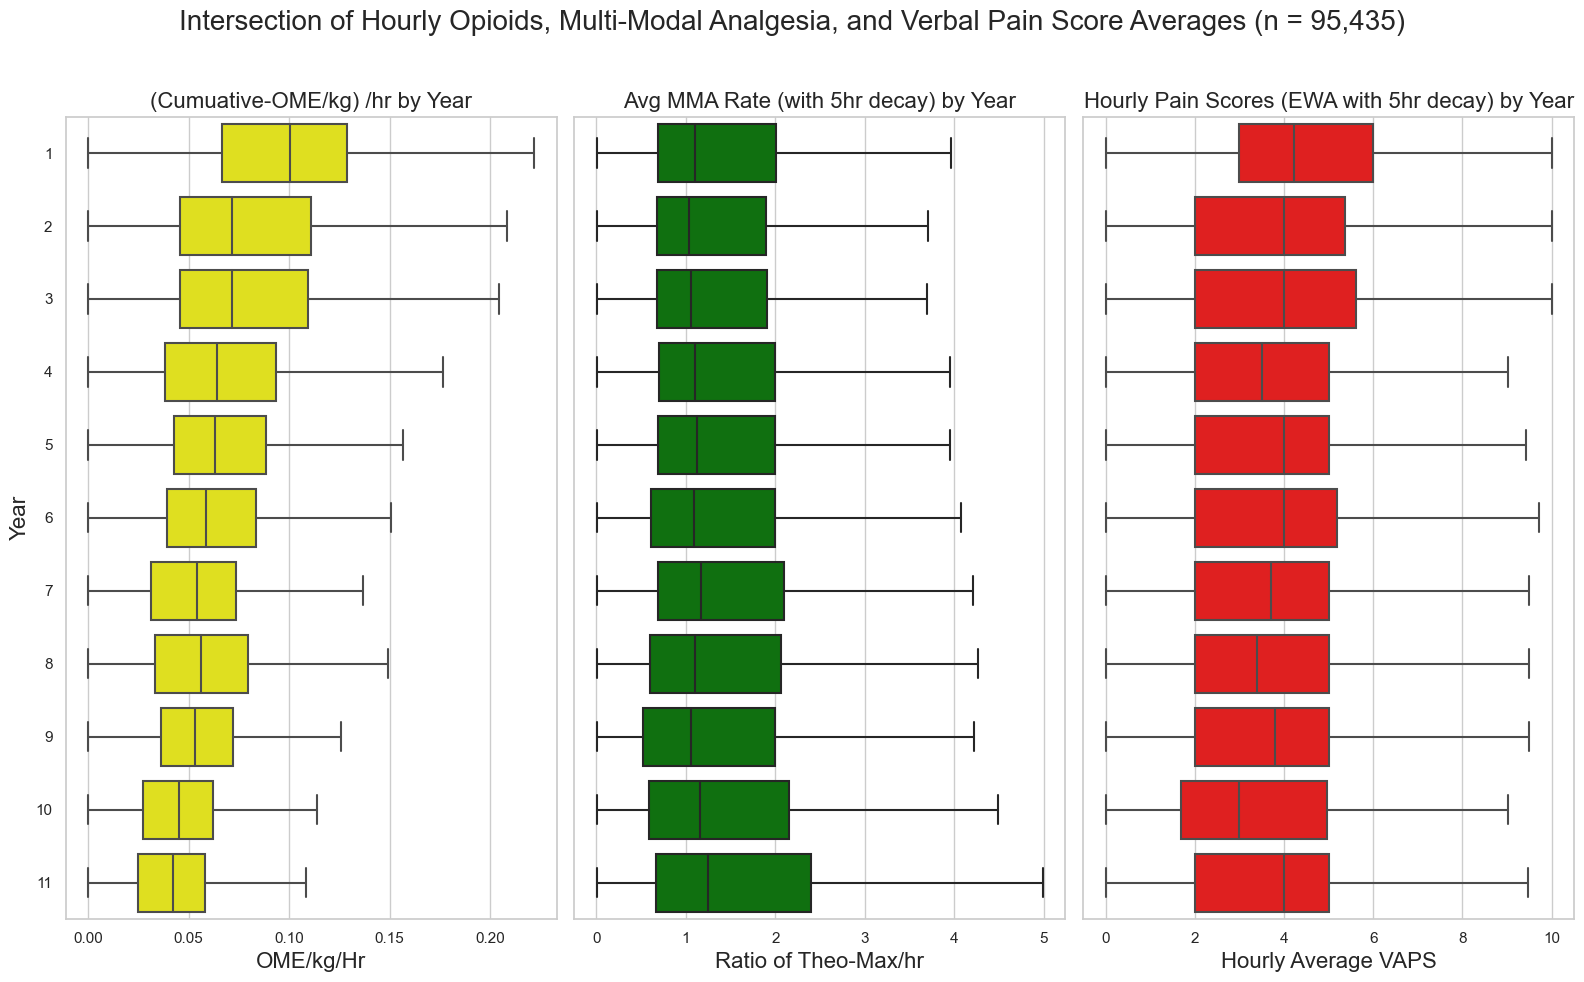

In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt



sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 3, figsize=(16, 10), sharey=True)

# Left: OME/KG/POH
sns.boxplot(
    data=master_plot,
    x='OME/KG/POH',
    y='YEAR_CAT',
    #order=year_order,
    ax=axes[0],
    orient='h',
    color = 'Yellow',
    #palette ='Blues_r',
    showfliers=False
)
axes[0].set_title("(Cumuative-OME/kg) /hr by Year", fontsize=16)
axes[0].set_xlabel("OME/kg/Hr", fontsize=16)
axes[0].set_ylabel("Year",fontsize=16)

sns.boxplot(
    data=master_plot,
    x='MMA_RATE',
    y='YEAR_CAT',
    #order=year_order,
    ax=axes[1],
    orient='h',
    color = 'Green',
    #palette = 'Reds',
    showfliers = False
)
axes[1].set_title("Avg MMA Rate (with 5hr decay) by Year", fontsize=16)
axes[1].set_xlabel("Ratio of Theo-Max/hr", fontsize=16)
axes[1].set_ylabel("")

# Right: NSAID_%MAX_POH
sns.boxplot(
    data=master_plot,
    x='VAPS_IMPUTED',
    y='YEAR_CAT',
    #order=year_order,
    ax=axes[2],
    orient='h',
    color = 'Red',
    #palette = 'Reds',
    showfliers = False
)
axes[2].set_title("Hourly Pain Scores (EWA with 5hr decay) by Year", fontsize=16)
axes[2].set_xlabel("Hourly Average VAPS", fontsize=16)
axes[2].set_ylabel("")


plt.suptitle("Intersection of Hourly Opioids, Multi-Modal Analgesia, and Verbal Pain Score Averages (n = 95,435)", fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [17]:
master_plot = master.dropna(subset=['OME/KG/POH', 'MMA_RATE', 'VAPS_IMPUTED']).copy()
master_plot.describe()

,EID,POH,OME/KG/POH,CEILING,dose start,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,AVG_VAPS,...,SUBJECT,YEAR,FAC,FAC_CODE,HT,AGE,BMI,HW,ASA,DSCPOH
count,97700.000000,97700.000000,97700.000000,97700.000000,97700.000000,0.0,8.000000e+00,8.000000,8.000000,39481.000000,...,97700.000000,97700.000000,97700.000000,97700.000000,97700.000000,97700.000000,97700.000000,97700.000000,97700.000000,97700.000000
mean,3933.394217,43.868158,0.067054,81.918057,39.982293,NaN,3.581267e+00,5.250000,1.182225,3.707075,...,3933.394217,6.810092,7.342119,7.342119,162.647398,15.510487,22.400664,35.400297,1.646121,97.045338
std,1802.604150,21.392059,0.111277,8.202759,22.264411,NaN,4.747513e-16,3.615443,1.081056,2.394154,...,1802.604150,2.859316,3.611265,3.611265,8.602447,1.653245,5.279801,9.832892,0.478175,29.907646
min,11.000000,0.000000,0.000000,64.083333,0.000000,NaN,3.581267e+00,1.000000,0.325570,0.000000,...,11.000000,1.000000,1.000000,1.000000,91.400000,13.001573,13.022841,15.000000,1.000000,64.083333
25%,2609.000000,26.000000,0.035229,72.583333,21.000000,NaN,3.581267e+00,2.750000,0.537190,2.000000,...,2609.000000,5.000000,5.000000,5.000000,157.000000,14.127217,18.785246,28.000000,1.000000,72.583333
50%,4087.000000,45.000000,0.056051,88.000000,40.000000,NaN,3.581267e+00,4.500000,0.805785,4.000000,...,4087.000000,7.000000,8.000000,8.000000,162.000000,15.292932,20.929526,36.000000,2.000000,93.983333
75%,5473.000000,61.000000,0.081195,88.000000,57.000000,NaN,3.581267e+00,7.000000,1.342975,5.000000,...,5473.000000,9.000000,10.000000,10.000000,168.000000,16.655887,24.456522,42.000000,2.000000,116.083333
max,6717.000000,87.000000,14.646899,88.000000,87.000000,NaN,3.581267e+00,11.000000,3.581267,10.000000,...,6717.000000,11.000000,13.000000,13.000000,195.500000,19.981914,45.333333,60.000000,2.000000,553.966667


In [18]:

master_plot = master_plot.sort_values(['EID', 'POH'])


cols = ['VAPS_IMPUTED', 'OME/KG/POH', 'MMA_RATE']


def lag1_autocorr(series):
    return series.autocorr(lag=1)

# Compute per column
results = []
for col in cols:
    autocorrs = master_plot.groupby('EID')[col].apply(lag1_autocorr)
    results.append({
        'column': col,
        'mean_lag1_autocorr': autocorrs.mean(),
        'median_lag1_autocorr': autocorrs.median(),
        'min_lag1_autocorr': autocorrs.min(),
        'max_lag1_autocorr': autocorrs.max()
    })

summary_df = pd.DataFrame(results)
print(summary_df)

C:\ProgramData\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\ProgramData\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)


         column  mean_lag1_autocorr  median_lag1_autocorr  min_lag1_autocorr  \
0  VAPS_IMPUTED            0.565435              0.599238          -0.510169   
1    OME/KG/POH            0.844772              0.918240          -0.483910   
2      MMA_RATE            0.157279              0.115004          -0.413831   

   max_lag1_autocorr  
0           0.967455  
1           1.000000  
2           1.000000  


In [19]:

master_plot = master_plot.sort_values(['EID', 'POH'])


for n in [-1, 1, 2]:
    master_plot[f'VAPS_{n:+}'] = master_plot.groupby('EID')['VAPS_IMPUTED'].shift(n)


# Filter rows where dose increased
condition = master_plot['OME/KG/POH'] > master_plot.groupby('EID')['OME/KG/POH'].shift(1)


for n in [-1, 1, 2]:
    master_plot.loc[condition, f'Delta_VAPS_VS_OME_{n:+}'] = (
        master_plot.loc[condition, f'VAPS_{n:+}'] - master_plot.loc[condition, 'VAPS_IMPUTED']
    )

In [20]:
# Sort by patient and POH
master2 = master_plot.sort_values(['EID', 'POH'])

# Create lead for pain score
master2['VAPS_lead1'] = master2.groupby('EID')['VAPS_IMPUTED'].shift(-1)

# Condition: OME did NOT increase
condition_not_increased = master2['OME/KG/POH'] <= master2.groupby('EID')['OME/KG/POH'].shift(1)

# Compute Delta +1 for non-increase rows
master2['OME_Delta_+1_no_increase'] = None
master2.loc[condition_not_increased, 'OME_Delta_+1_no_increase'] = (
    master2.loc[condition_not_increased, 'VAPS_lead1'] - master2.loc[condition_not_increased, 'VAPS_IMPUTED']
)


master2.drop(columns=['VAPS_lead1'], inplace=True)

In [21]:

master3 = master2.sort_values(['EID', 'POH'])

# Create lag/lead pain features
for n in [-1, 1, 2]:
    master3[f'VAPS_{n:+}'] = master3.groupby('EID')['VAPS_IMPUTED'].shift(n)


# Filter rows where dose increased
condition = master3['MMA_RATE'] > master3.groupby('EID')['MMA_RATE'].shift(1)

# Compute deltas
for n in [-1, 1, 2]:
    master3.loc[condition, f'Delta_VAPS_VS_MMA_{n:+}'] = (
        master3.loc[condition, f'VAPS_{n:+}'] - master3.loc[condition, 'VAPS_IMPUTED']
    )

In [22]:

master = master3.sort_values(['EID', 'POH'])

# Create lead for pain score
master['VAPS_lead1'] = master.groupby('EID')['VAPS_IMPUTED'].shift(-1)

# Condition: OME did NOT increase
condition_not_increased = master['MMA_RATE'] <= master.groupby('EID')['MMA_RATE'].shift(1)

# Compute Delta +1 for non-increase rows
master['MMA_Delta_+1_no_increase'] = None
master.loc[condition_not_increased, 'MMA_Delta_+1_no_increase'] = (
    master.loc[condition_not_increased, 'VAPS_lead1'] - master.loc[condition_not_increased, 'VAPS_IMPUTED']
)

#
master.drop(columns=['VAPS_lead1'], inplace=True)

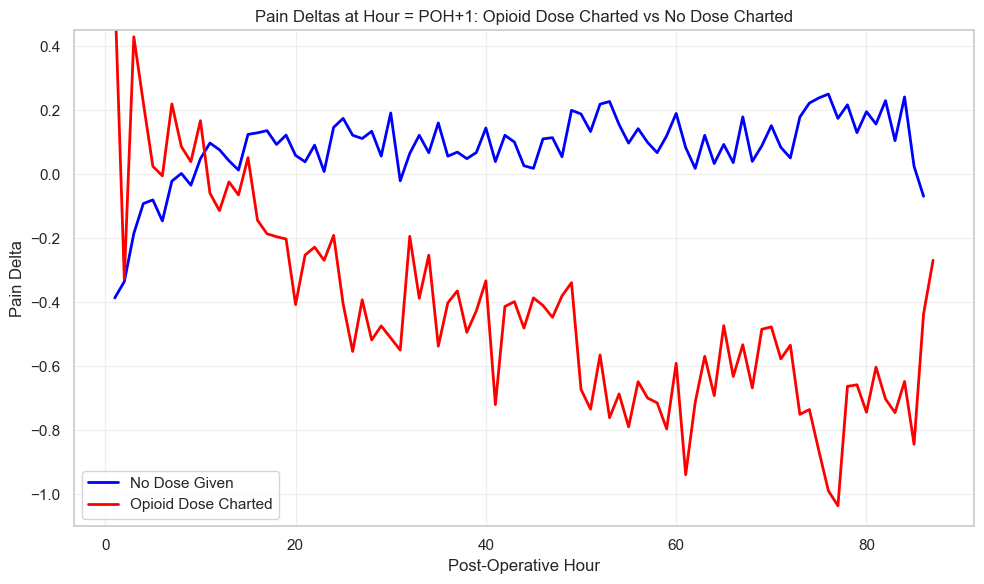

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns


master = master.sort_values('POH')


fig, ax = plt.subplots(figsize=(10, 6))

# Plot Delta_-1
sns.lineplot(data=master, x='POH', y='OME_Delta_+1_no_increase', color='blue', linewidth=2, errorbar=None, label='No Dose Given', ax=ax)

# Plot Delta_+4
sns.lineplot(data=master, x='POH', y='Delta_VAPS_VS_OME_+1', color='red', linewidth=2,errorbar=None,  label='Opioid Dose Charted', ax=ax)


#



ax.set_xlabel('Post-Operative Hour')
ax.set_ylabel('Pain Delta')
plt.title('Pain Deltas at Hour = POH+1: Opioid Dose Charted vs No Dose Charted')


plt.grid(alpha=0.3)
fig.tight_layout()
plt.ylim(-1.1, 0.45)
ax.legend(loc='lower left')
plt.show()


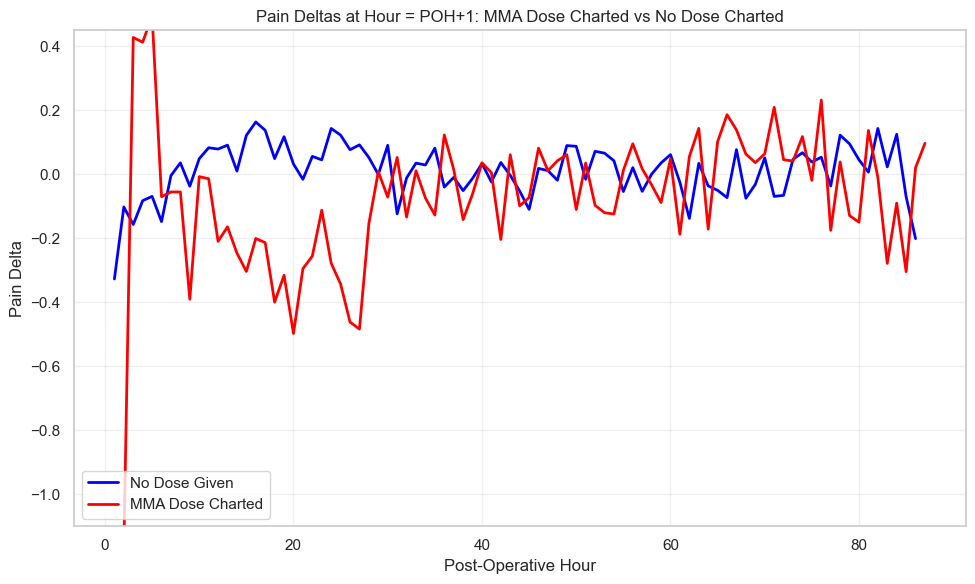

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns


master = master.sort_values('POH')


fig, ax = plt.subplots(figsize=(10, 6))

# Plot Delta_-1
sns.lineplot(data=master, x='POH', y='MMA_Delta_+1_no_increase', color='blue', linewidth=2, errorbar=None, label='No Dose Given', ax=ax)

# Plot Delta_+4
sns.lineplot(data=master, x='POH', y='Delta_VAPS_VS_MMA_+1', color='red', linewidth=2,errorbar=None,  label='MMA Dose Charted', ax=ax)


#


# Labels and title
ax.set_xlabel('Post-Operative Hour')
ax.set_ylabel('Pain Delta')
plt.title('Pain Deltas at Hour = POH+1: MMA Dose Charted vs No Dose Charted')

# Add grid and tighten layout
plt.grid(alpha=0.3)
fig.tight_layout()
plt.ylim(-1.1, 0.45)
ax.legend(loc='lower left')
plt.show()


In [25]:
master['MMA_Delta_+1_no_increase'].describe()

count     75262.0
unique    17089.0
top           0.0
freq      25440.0
Name: MMA_Delta_+1_no_increase, dtype: float64

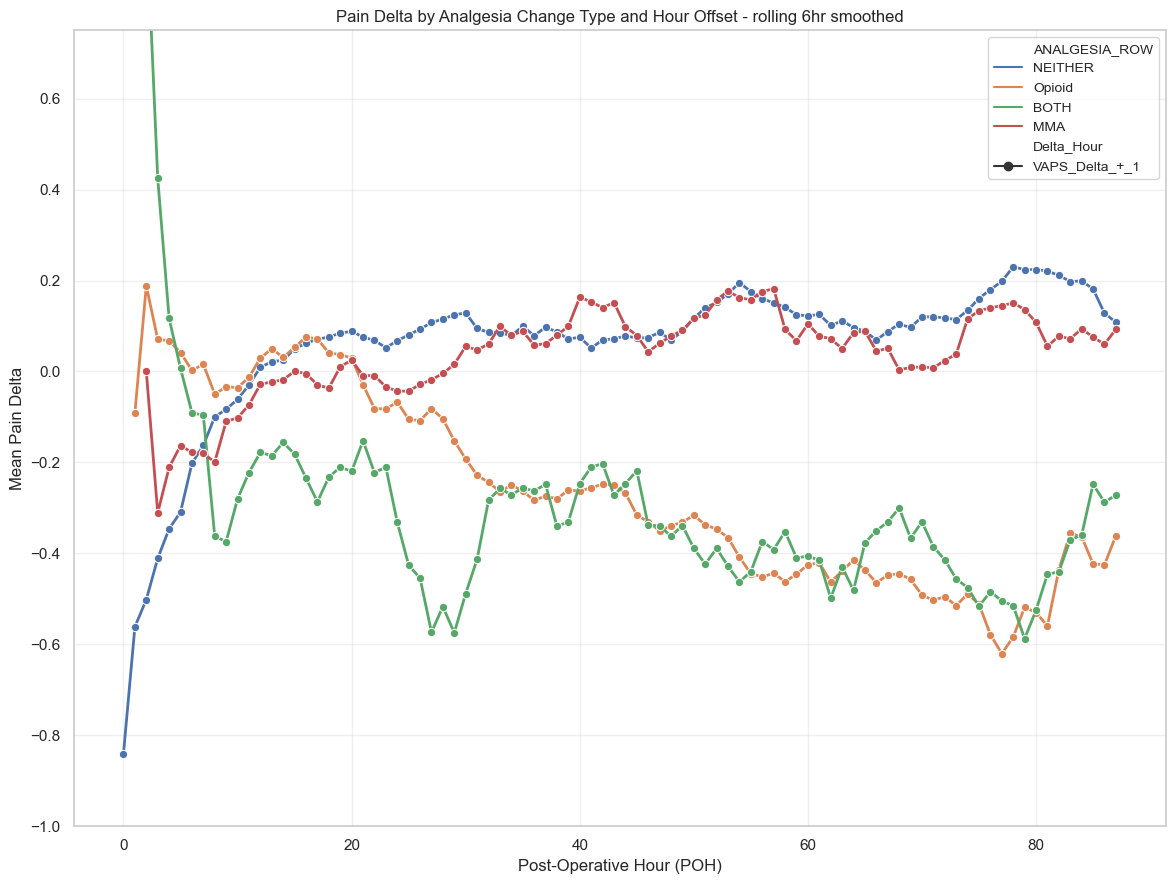

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


master = master.sort_values(['EID', 'POH'])


master['OME_lag1'] = master.groupby('EID')['OME/KG/POH'].shift(1)
master['MMA_lag1'] = master.groupby('EID')['MMA_RATE'].shift(1)


cond_ome_increase = master['OME/KG/POH'] > master['OME_lag1']
cond_mma_increase = master['MMA_RATE'] > master['MMA_lag1']

master['ANALGESIA_ROW'] = 'NEITHER'
master.loc[cond_ome_increase & ~cond_mma_increase, 'ANALGESIA_ROW'] = 'Opioid'
master.loc[cond_mma_increase & ~cond_ome_increase, 'ANALGESIA_ROW'] = 'MMA'
master.loc[cond_ome_increase & cond_mma_increase, 'ANALGESIA_ROW'] = 'BOTH'


master['VAPS_lead_1'] = master.groupby('EID')['VAPS_IMPUTED'].shift(-1)
master['VAPS_Delta_+_1'] = master[f'VAPS_lead_1'] - master['VAPS_IMPUTED']


agg_cols = ['POH', 'ANALGESIA_ROW']
delta_cols = ['VAPS_Delta_+_1']
agg_df = master.groupby(agg_cols)[delta_cols].mean().reset_index()





plot_df = agg_df.melt(id_vars=['POH', 'ANALGESIA_ROW'], value_vars=delta_cols,
                      var_name='Delta_Hour', value_name='Pain_Delta')


# Apply rolling 4-hour average within each ANALGESIA_ROW group
plot_df['Pain_Delta_Smoothed'] = plot_df.groupby('ANALGESIA_ROW')['Pain_Delta'] \
                                        .transform(lambda x: x.rolling(window=6, min_periods=1).mean())



fig, ax = plt.subplots(figsize=(12,9))
sns.lineplot(data=plot_df, x='POH', y='Pain_Delta_Smoothed', hue='ANALGESIA_ROW',
             style='Delta_Hour', markers=True, dashes=False, linewidth=2, ax=ax, errorbar=None)


ax.set_xlabel('Post-Operative Hour (POH)')
ax.set_ylabel('Mean Pain Delta')
plt.title('Pain Delta by Analgesia Change Type and Hour Offset - rolling 6hr smoothed')


ax.legend(title='', loc='upper right', frameon=True, fontsize=10)


plt.grid(alpha=0.3)
fig.tight_layout()
plt.ylim(-1., 0.75)
plt.show()

In [27]:
import pandas as pd
from scipy.stats import ttest_ind, mannwhitneyu, skew
from IPython.display import display, HTML

def compare_years_extended(df, value_col, year_col='YEAR', years=(1, 11)):
    # Filter for years
    g1 = df[df[year_col] == years[0]][value_col].dropna()
    g2 = df[df[year_col] == years[1]][value_col].dropna()
    
    
    stats = {
        'Year-1 Count': len(g1),
        'Year-11 Count': len(g2),
        'Year-1 Mean': g1.mean(),
        'Year-11 Mean': g2.mean(),
        'Year-1 std': g1.std(),
        'Year-11 std': g2.std(),
        'Year-1 var': g1.var(),
        'Year-11 var': g2.var(),
        'Variance ratio': g2.var() / g1.var() if g1.var() != 0 else None,

    }
    
    # Decide test
    if len(g1) > 30 and len(g2) > 30:
        test_name = 't-test'
        stat, p = ttest_ind(g1, g2, equal_var=False)
    else:
        test_name = 'Mann-Whitney U'
        stat, p = mannwhitneyu(g1, g2, alternative='two-sided')
    
    interpretation = 'Significant' if p < 0.05 else 'Not Significant'
    
    stats.update({
        'Test': test_name,
        'Statistic': stat,
        'p-value': p,
        'Interpretation': interpretation
    })
    
    return stats


oba_result = compare_years_extended(master_plot, 'OME/KG/POH')
df_clean_result = compare_years_extended(master_plot, 'AVG_VAPS')


summary = pd.DataFrame([oba_result, df_clean_result], index=['OME/KG/HR', 'AVG_VAPS'])


styled = summary.style.format({
    'Year-1_mean': '{:.2f}',
    'Year-11_mean': '{:.2f}',
    'Year-1_std': '{:.2f}',
    'Year-11_std': '{:.2f}',
    'Year1_variance': '{:.2f}',
    'Year11_variance': '{:.2f}',
    'Variance_ratio': '{:.2f}',
    'Statistic': '{:.3f}',
    'p-value': '{:.4f}'
}).highlight_between(subset=['p-value'], left=0, right=0.05, color='lightgreen')


display(HTML(styled.to_html()))

,Year-1 Count,Year-11 Count,Year-1 Mean,Year-11 Mean,Year-1 std,Year-11 std,Year-1 var,Year-11 var,Variance ratio,Test,Statistic,p-value,Interpretation
OME/KG/HR,4276,9944,0.103694,0.048125,0.050078,0.058215,0.002508,0.003389,1.351359,t-test,57.706,0.0000,Significant
AVG_VAPS,1795,3608,4.365924,3.741454,2.596378,2.264362,6.741180,5.127337,0.760599,t-test,8.679,0.0000,Significant


In [28]:
print(summary)

           Year-1 Count  Year-11 Count  Year-1 Mean  Year-11 Mean  Year-1 std  \
OME/KG/HR          4276           9944     0.103694      0.048125    0.050078   
AVG_VAPS           1795           3608     4.365924      3.741454    2.596378   

           Year-11 std  Year-1 var  Year-11 var  Variance ratio    Test  \
OME/KG/HR     0.058215    0.002508     0.003389        1.351359  t-test   
AVG_VAPS      2.264362    6.741180     5.127337        0.760599  t-test   

           Statistic       p-value Interpretation  
OME/KG/HR  57.705592  0.000000e+00    Significant  
AVG_VAPS    8.679358  6.245561e-18    Significant  
